# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

In [3]:
from torch.utils.data import DataLoader

# create dataloaders
batch_size = 32

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [4]:
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

epoch:   0, batch index:  187, train loss: 1.89477
epoch:   0, batch index:  374, train loss: 0.91780
epoch:   0, batch index:  561, train loss: 0.60040
epoch:   0, batch index:  748, train loss: 0.48837
epoch:   0, batch index:  935, train loss: 0.44126
epoch:   0, batch index: 1122, train loss: 0.37715
epoch:   0, batch index: 1309, train loss: 0.40283
epoch:   0, batch index: 1496, train loss: 0.36612
epoch:   0, batch index: 1683, train loss: 0.40105
epoch:   0, batch index: 1870, train loss: 0.29359
epoch:   0, batch index: 1875, train loss: 0.32631
==>>> epoch: 0, batch index: 313, test loss: 0.37971, acc: 0.908


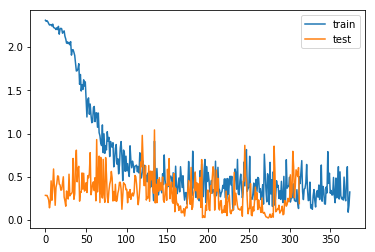

In [5]:
model = MLPNet()

learning_rate = 0.01
momentum = 0.5
num_epochs = 1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):

    # train
    avg_loss = 0
    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        if(batch_idx % int(len(train_dloader)/len(test_dloader)) == 0): train_loss_history.append(loss.item())
        #train_loss_history.append(loss.item())
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
                    
        if (batch_idx+1) % int(len(train_dloader)/10) == 0 or (batch_idx+1) == len(train_dloader):
            print ('epoch: {:3d}, batch index: {:4d}, train loss: {:.5f}'.format(
                epoch, batch_idx+1, avg_loss))     
            
    # test
    correct_cnt, total_cnt, ave_loss = 0, 0, 0
    avg_loss = 0
    
    for batch_idx, (x, target) in enumerate(test_dloader):
        out = model(x)
        loss = criterion(out, target)
        test_loss_history.append(loss.item())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
    
        # smooth average
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1
        
        if(batch_idx+1) % 500 == 0 or (batch_idx+1) == len(test_dloader):
            print ('==>>> epoch: {}, batch index: {}, test loss: {:.5f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, avg_loss, correct_cnt.item() * 1.0 / total_cnt))

#TODO GET TEST LOSS AND ACCURACY CORRECT
#TODO SCALE TEST LOSS TO MATCH TRAIN LOSS FOR PLOTTING

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_loss_history, label="train");
ax.plot(test_loss_history, label="test");
ax.legend();

## Testing Federation

Up to this point, we've trained an MNIST model with pytorch. The plot is terrible because I'm not keeping scroe correctly, but the model is indeed training properly.

In [6]:
train_dloader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
import federated

dataloaders = []
dataloaders.append(train_dloader)
#dataloaders.append(test_dloader)


data = {
    'dataloaders': dataloaders,
    'Xtest': [1],
    'ytest': [1],
}


# This is a hack to satisfy requirements in federated.py
def make_model():
    return MLPNet()


#print(data["test"].test_data.type())
#print(len(data["dataloaders"][1]))
#print(list(enumerate(data["dataloaders"][1])
#print(sum(1 for _ in enumerate(data["dataloaders"][1])))

manager = federated.FederatedManager(
    data["dataloaders"],
    make_model,
    nn.CrossEntropyLoss,
    data["Xtest"],
    data["ytest"],
)

for i in range(3):
    manager.round()
    print(i, manager.manager_loss_history[-1])


RuntimeError: bool value of Tensor with more than one value is ambiguous